## Overview
This is my attempt for the first assignment of the Machine Learning course Fall 2022.

### Note
Please make sure the dataset is saved in the ***same working directory*** as this jupyter notebook

## Preliminary: imports and loading data
In this section, I load the data, import the necessary libraries needed for the rest of the notebook. 

In [1]:
import os
import math
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
# setting seaborn to darkgrid for a more detailed display of the values
STYLE = 'darkgrid'
sns.set_style(STYLE)

In [2]:
wd = os.getcwd()
dataset_name = "a1_dataset.csv"
file_path = os.path.join(wd, dataset_name) # setting the location of the file 

In [3]:
df_org = pd.read_csv(file_path) # save original datafrae 
df = df_org.copy() # copy to work on

## Exploring the data 
In this section, I explore the dataset, prepare it: (data cleaning and preprocessing), analyse a number of aspects and interations in the data before building models for our prediction purposes 
### Preprocessing the data

In [4]:
print(df.shape)
print(df.columns)
df.info() # the only column with missing values is 'var4'

(925, 8)
Index(['target', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 57.9+ KB


In [5]:
# let's rename the columns
new_names = {"target": "y"}
y = df['target']
for i in range(1, len(df.columns) + 1):
    new_names[f'var{str(i)}'] = f"f{str(i)}"
df = df.rename(columns=new_names)
print(df.columns)
# I will drop the target column and add it to the dataframe when needed
df.drop('y', inplace=True, axis=1)

Index(['y', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'], dtype='object')


### Target variable distribution

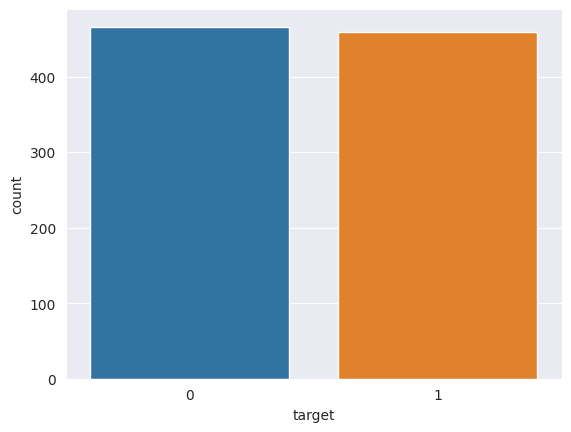

In [6]:
sns.countplot(x=y)
plt.show()

### Numerical and categorial columns
It is crucial to divide the data into categorical and numerical columns as each column should be treated differently. In this subsection, I perform this task in a systematic way:

In [7]:
# this method returns a tuple of the column names : numerical then categorical
def num_cat(df):
    num = df.select_dtypes(np.number).columns.values
    cat = df.select_dtypes(['object', 'category']).columns.values
    return num, cat


num_cols, cat_cols = num_cat(df)

### Understanding the data: visualization, grouping, descriptive analysis

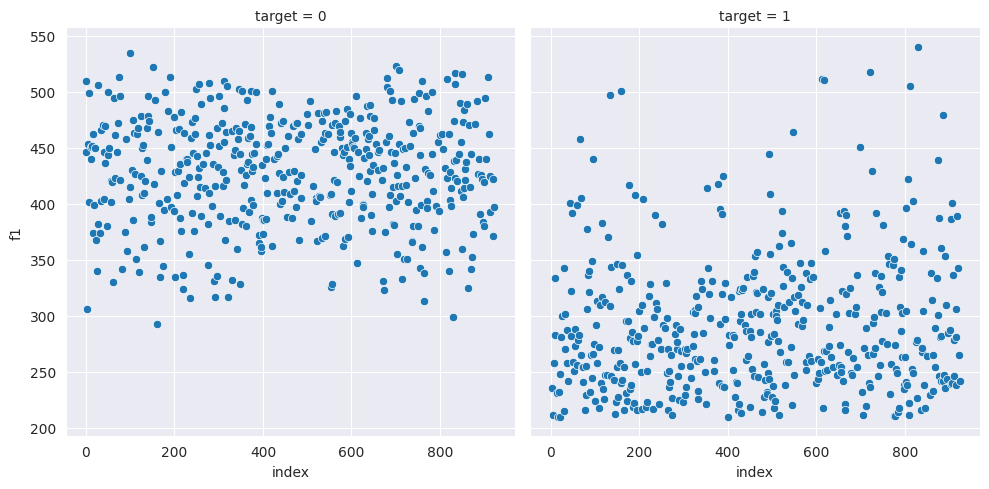

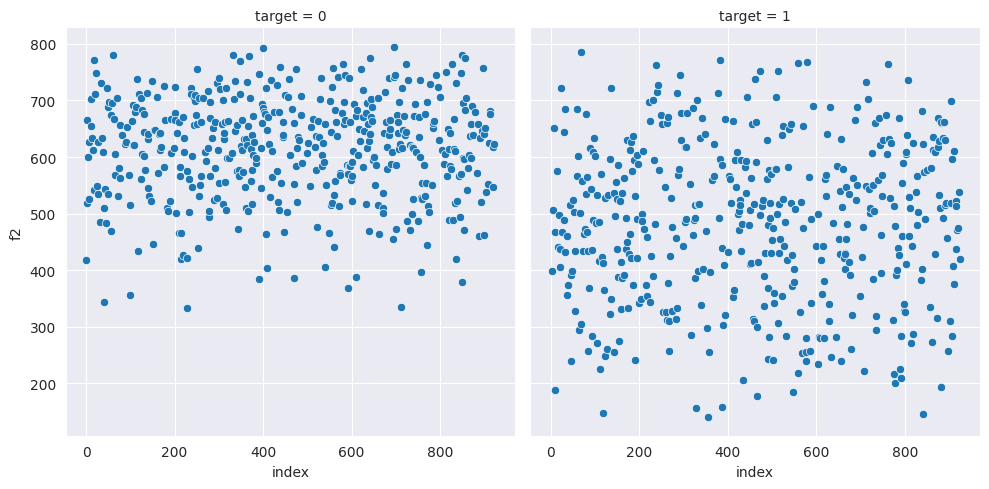

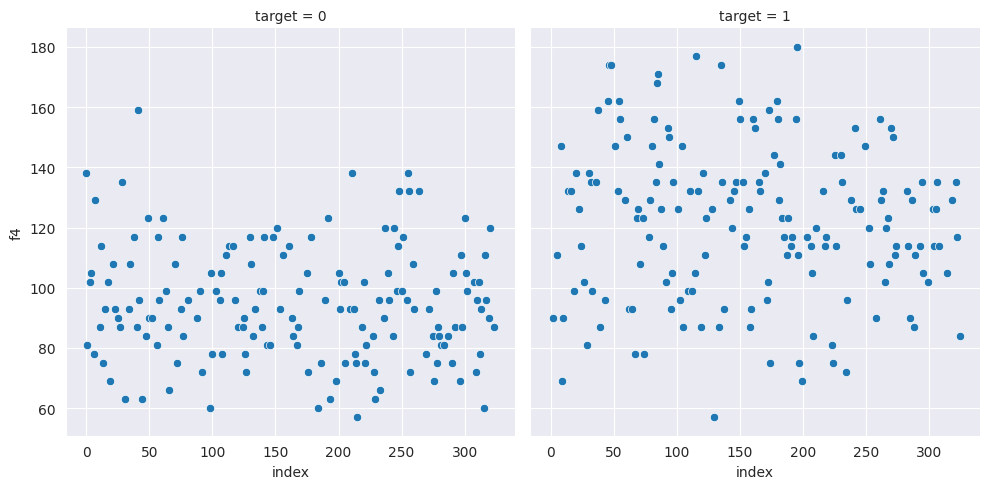

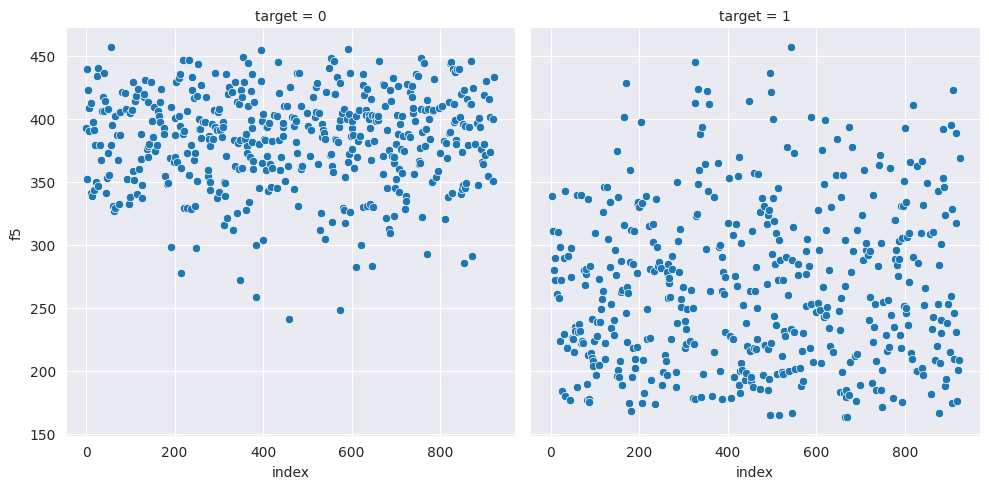

In [8]:
# this method is short for first impression numerical, where I consider the values and its effect 
def first_imp_num(df, y, col_name):
    df_c = df.dropna(axis=1).copy() # a copy with non Nan values
    f1_fig = sns.relplot(data=df, x=df_c.index.values, y=col_name, col=y, col_order=[0, 1])
    f1_fig.set(xlabel="index", ylabel=col_name)
    plt.show()

for col in num_cols:
    first_imp_num(df, y, col)


In [9]:
# analysing the numerical columns
from empiricaldist import Cdf
    
def cdf_num(df, y, col_name, target=False):
    df_c = df.dropna(axis=0).copy() # take a copy with no nan values in it.
    df_c['y'] = y.copy()
    if not target:
        col_cdf = Cdf.from_seq(df[col_name])
        col_cdf.plot()
        plt.xlabel(f'{col_name}')
        plt.ylabel(f'CDF for {col_name}')
        plt.show()         
    else :    
        cdf_1 = Cdf.from_seq(df_c[df_c['y'] == 1][col_name])
        cdf_0 = Cdf.from_seq(df_c[df_c['y'] == 0][col_name])
        cdf_1.plot(label='y == 1')
        cdf_0.plot(label='y == 0')
        plt.xlabel(f'{col_name}')
        plt.ylabel(f'CDF for {col_name}')
        plt.legend()
        plt.show()        

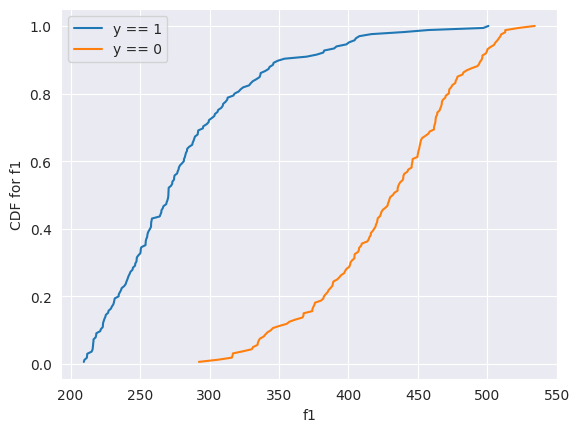

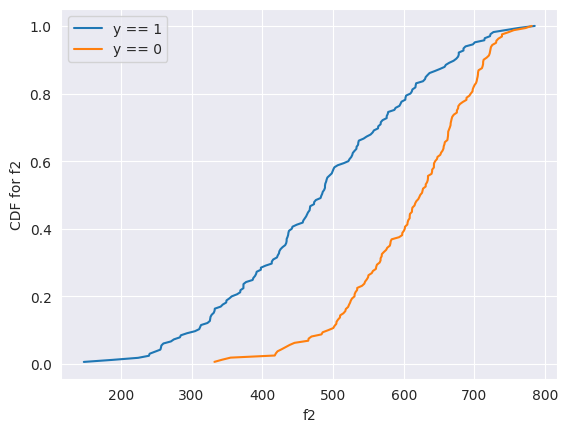

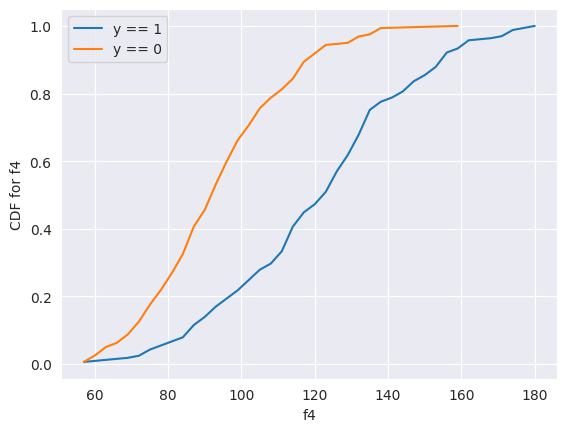

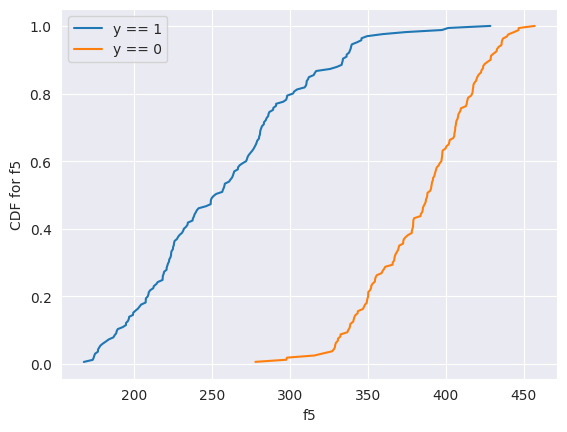

In [10]:
for col in num_cols:
    cdf_num(df, y, col, target=True)

#### Conclusion: 
considering all numerical features (except for f4), negative examples tend to have high values for such features. The column f4 is not as informative as no clear trend or correlation (linear or non-linear) can be seen. This is possibly the result of the large number of missing values.

### Analysing categorical features
The features f3, f6 and f7 are categorical features. The interacations should be understood in depth.

#### Fixing f7
As the 'f7' includes invalid dates, more preprocessing steps should be taken.

In [11]:
# let's set the last column to datetime for further manipulation
try:    
    df['f7'] = pd.to_datetime(df['f7']) 
except:
    print("Certain dates are semantically invalid")
    
from dateutil import parser

# for futher manipulation we need to determine the invalid dates
def validate_dates(row):
    try:
        row['valid_date'] = parser.parse(row['f7']) # if the data isinvalid an error will raise,
    except ValueError:
        row['valid_date'] = False # the except block will catch it and set the field to False
    return row

df = df.apply(validate_dates, axis=1)
invalid_dates = df[df['valid_date'] == False]['f7'].values
# drop the additional column
df.drop('valid_date', axis=1, inplace=True)

Certain dates are semantically invalid


In [12]:
print(invalid_dates) # this is the list of invalid dates in the dataframes
# let's reduce these dates by 24 hours

def fix_dates(row):
    if row['f7'] in invalid_dates:
        date, time = row['f7'].split()
        # change the 29 to 28
        date = date[:-2] + "28"
        row['f7'] = date + " " + time
    return row

df = df.apply(fix_dates, axis=1)

df['f7'] = pd.to_datetime(df['f7'])

['2019-02-29 12:31:57' '2019-02-29 18:06:21' '2019-02-29 11:00:06'
 '2019-02-29 23:56:06' '2019-02-29 19:26:35']


In [13]:
print(df.dtypes)
# now that the 7th column is converted to datetime, we can futher break it down and tackle each component of the date: year, month, day, time
year = 'year'
month = 'month'
day = 'day'
time = 'time'
date_cols = [year, month, day, time]
def decompose_date(row):
    row[year] = row['f7'].year
    row[month] = row['f7'].month
    row[day] = row['f7'].day
    row[time] = row['f7'].time
    return row

df = df.apply(decompose_date, axis=1)
print()

f1           float64
f2           float64
f3            object
f4           float64
f5           float64
f6            object
f7    datetime64[ns]
dtype: object



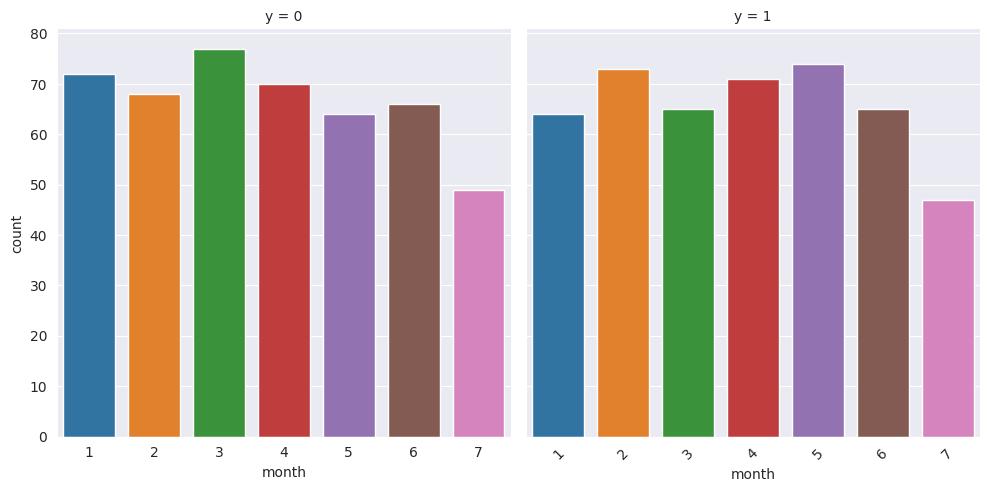

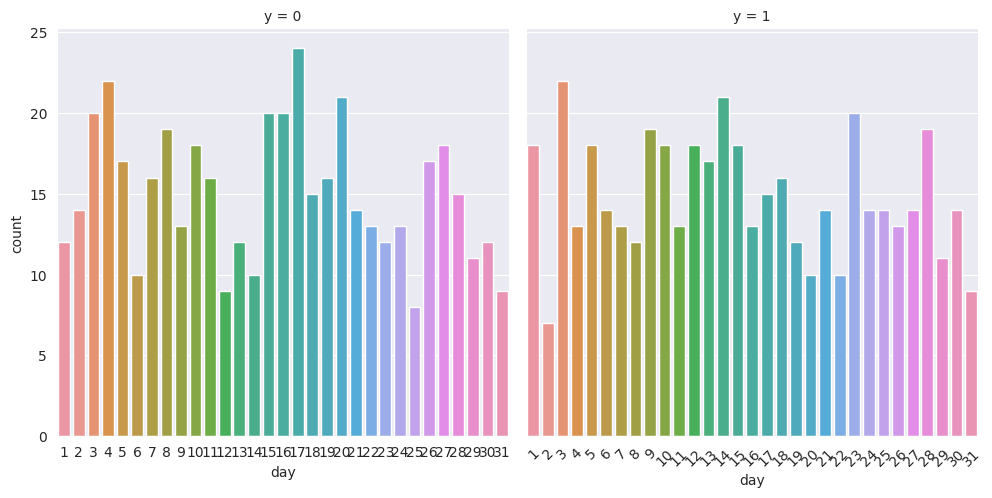

In [14]:
for c in date_cols[1:-1]:
    df_c = df.copy()
    df_c['y'] = y
    fig = sns.catplot(data=df_c, kind='count', x=c, col='y', col_order=[0, 1])
    fig.set(xlabel=c, ylabel='count')
    plt.xticks(rotation=45)
    plt.show()

In [15]:
# the only year present is 2019. The data concerns countries so time within a single day cannot be significant
# year, day and  time columns are to be dropped.
df = df.drop(year, axis=1)
df = df.drop(time, axis=1)
df = df.drop(day, axis=1)
df = df.drop('f7', axis=1)

In [16]:
# let's consider the number of positively classed examples within each month
df['y'] = y.copy()
print(pd.pivot_table(df, index=month, values='y', aggfunc=['count', 'mean']))
# we can see that the month's value does not affect the class distribution

      count      mean
          y         y
month                
1       136  0.470588
2       141  0.517730
3       142  0.457746
4       141  0.503546
5       138  0.536232
6       131  0.496183
7        96  0.489583


#### 'f3' Column
As the column 'f3' represents countries' (areas') names, it is recommended to normalize the string representation and remove any unnecessary characters.

In [17]:
def clean_country(row):
    row['f3'] = row['f3'].strip().lower()
    # remove any string between parentheses if they exist
    row['f3'] = re.sub('\(.*\)', "", row['f3'])
    # remove any string between brackets if they exist
    row['f3'] = re.sub('\[.*\]', "", row['f3'])
    return row

df = df.apply(clean_country, axis=1)

In [18]:
# set date with the rest of the columns
def set_date(row):
    row['date'] = pd.Timestamp(year=2019, month=row[month], day=row[day])
    return row

In [19]:
# let's encode f6 as no:0 and yes:1
print(df['f6'].value_counts())
# the column's integrity is verified
encode_dict = {"no":0, "yes":1}
df['f6'] = df['f6'].apply(encode_dict.get)

# for f in num_cols:
#     print(pd.pivot_table(df, index='f3', columns=month, values=f, aggfunc=[np.mean]))
# print(pd.pivot_table(df, index='f3', columns=month, values='f6', aggfunc=[np.mean]))

f1_trend = pd.pivot_table(df, index='f3', columns=month, values='f1', aggfunc=[np.mean])
f2_trend = pd.pivot_table(df, index='f3', columns=month, values='f2', aggfunc=[np.mean])
f4_trend = pd.pivot_table(df, index='f3', columns=month, values='f4', aggfunc=[np.mean])
f5_trend = pd.pivot_table(df, index='f3', columns=month, values='f5', aggfunc=[np.mean])
f6_trend = pd.pivot_table(df, index='f3', columns=month, values='f6', aggfunc=[np.mean])

yes    483
no     442
Name: f6, dtype: int64


In [20]:
# let's account the ratio of times each country was classified positively
country_y_ratio = pd.pivot_table(df, index='f3', values='y', aggfunc=['count', 'mean']).sort_values(by=[('mean', 'y'), ('count', 'y')], ascending=[False, False])
print(country_y_ratio.iloc[:50,:]) 


                                count      mean
                                    y         y
f3                                             
ethiopia                            6  1.000000
hungary                             5  1.000000
kenya                               4  1.000000
latvia                              4  1.000000
liechtenstein                       4  1.000000
uganda                              4  1.000000
lithuania                           3  1.000000
macao                               3  1.000000
netherlands                         3  1.000000
spain                               3  1.000000
andorra                             2  1.000000
maldives                            2  1.000000
montenegro                          2  1.000000
new caledonia                       2  1.000000
saint barthelemy                    2  1.000000
sao tome and principe               2  1.000000
sierra leone                        2  1.000000
british indian ocean territory      1  1

#### f3 Encoding
The dataframe displayed by the cell above represents the basis for an adequate target encoding of the 'f3' feature. The proposed encoding is:
$\begin{align} count \cdot ratio \end{align}$
* count: the country's number of occurrences
* ratio: the ratio of positive classes associated with these occurrences

In [21]:
# # let's investigate the effect of the months and days further.
# f1_trend = pd.pivot_table(df, index='f3', columns=y, values='f1', aggfunc=[np.mean, np.median, 'count'])
# f2_trend = pd.pivot_table(df, index='f3', columns=y, values='f2', aggfunc=[np.mean, np.median,'count'])
# f4_trend = pd.pivot_table(df, index='f3', columns=y, values='f4', aggfunc=[np.mean, np.median, 'count'])
# f5_trend = pd.pivot_table(df, index='f3', columns=y, values='f5', aggfunc=[np.mean, np.median, 'count'])

# print(f1_trend)
# print(f2_trend)
# print(f4_trend)
# print(f5_trend)


#### Month, area(f3) and target
In this section I will study the effect of the combination: month, area, and target class on the different numerical values (except 'f4').
The procedure can be described as follows:
* separate the positive and negative rows into two dataframes
* for each dataframe group the rows by 'f3' and aggregate a given numerical feature on the month column: calculate the mean value at each month by country (area/f3)
* visualize the evolution of the mean with respect to month column


The mean in this case is a representative statistic as there is a less than 3 values for each combination of (country, month)

In [22]:
import random
df_1 = df[df['y'] == 1]
df_0 = df[df['y'] == 0]


def feat_month_country(feat, aggs=None, num_display=2, num_samples=20):
    if aggs is None:
        aggs = [np.mean]
    # visualize positive 
    f_months1 = pd.pivot_table(df_1, index='f3', columns=month, values=feat, aggfunc=[np.mean]) # calculate the mean of the feature accross different months for positive rows
    f_months0 = pd.pivot_table(df_0, index='f3', columns=month, values=feat, aggfunc=[np.mean]) # calculate the mean of the feature accross different months for negative rows

    for i in range(1, num_display + 1):
        c0 = f_months1.index.values.tolist()
        c0_sample = random.sample(c0, min(num_samples, len(c0))) 

        for c in c0_sample:
            g = sns.lineplot(x=range(1, 8), y=f_months1.loc[c,:])
        g.set(xlabel='months', ylabel=feat, label=c)
        g.set_title(f"evolution of {feat} with respect to months for positive areas: plot {str(i)}")
        plt.show()
        
    # visualize negative
    for i in range(1, num_display + 1):
        c0 = f_months0.index.values.tolist()
        c0_sample = random.sample(c0, min(num_samples, len(c0))) 

        for c in c0_sample:
            g = sns.lineplot(x=range(1, 8), y=f_months0.loc[c,:])
        g.set(xlabel='months', ylabel=feat, label=c)
        g.set_title(f"evolution of {feat} with respect to months for negative areas: plot {str(i)}")
        plt.show()
    

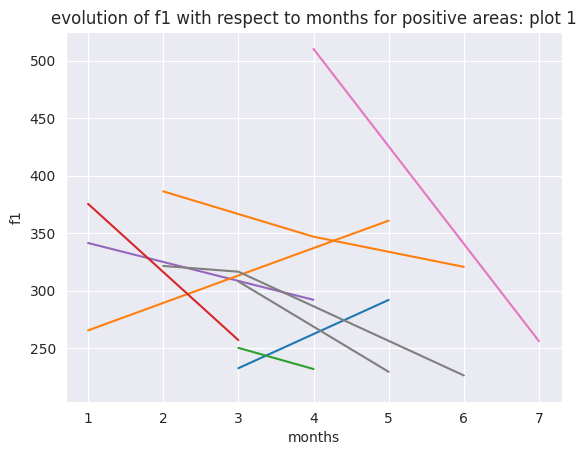

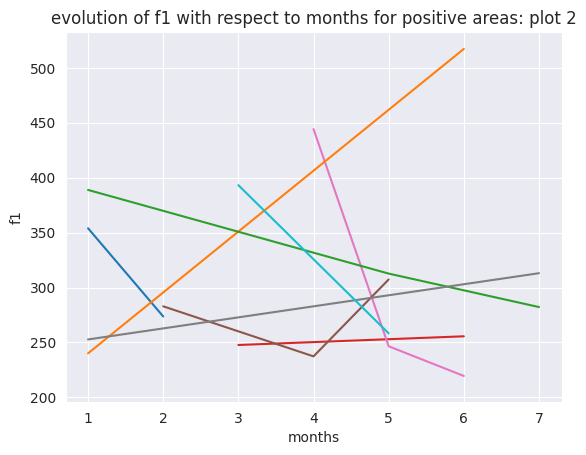

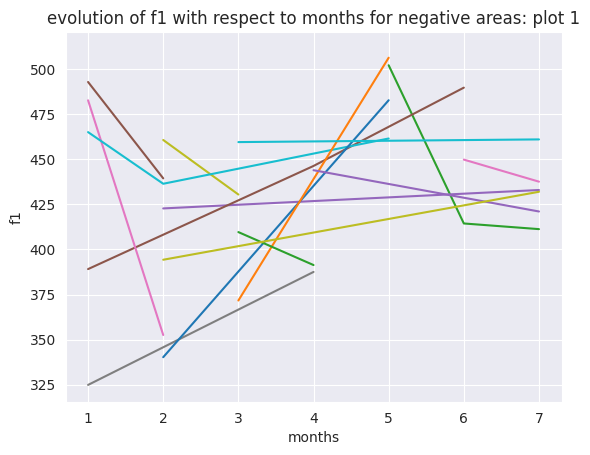

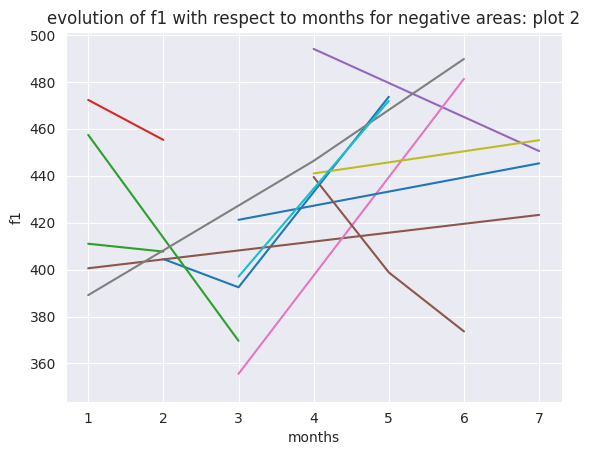

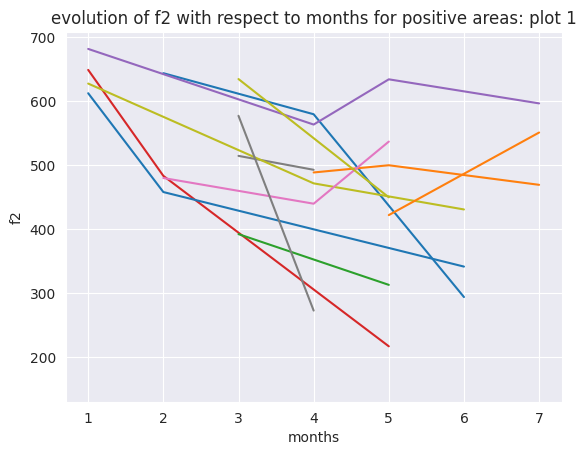

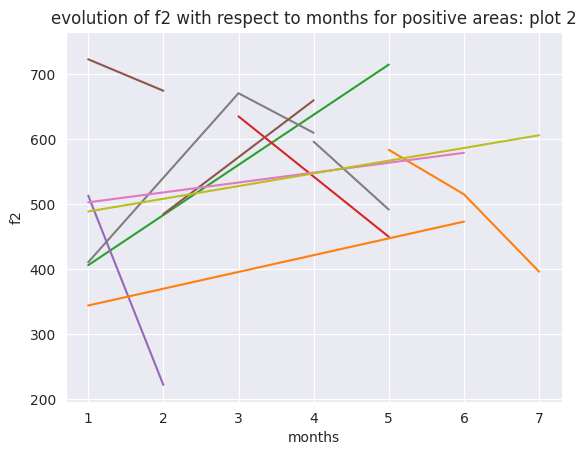

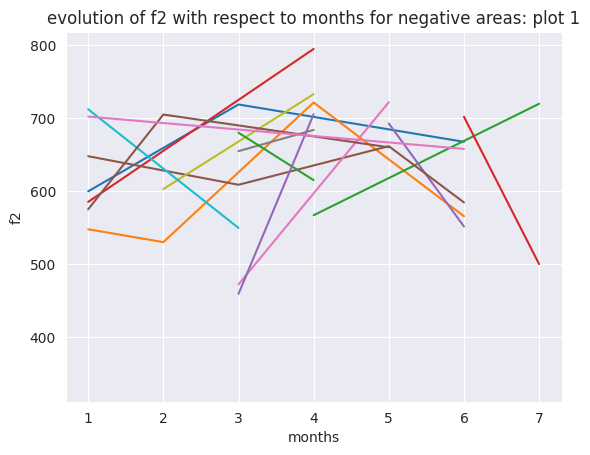

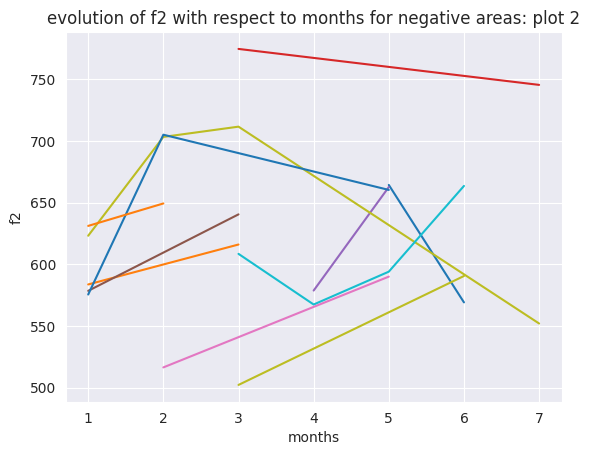

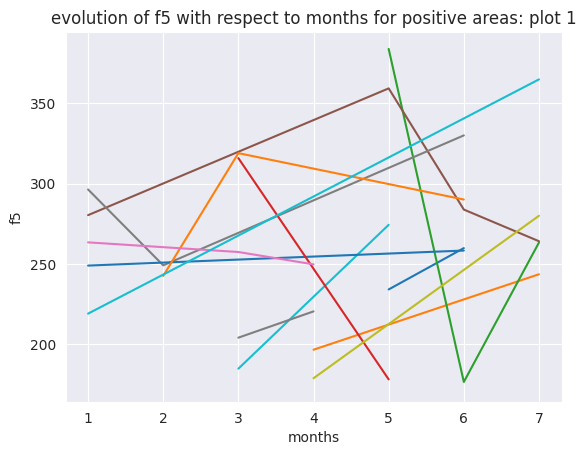

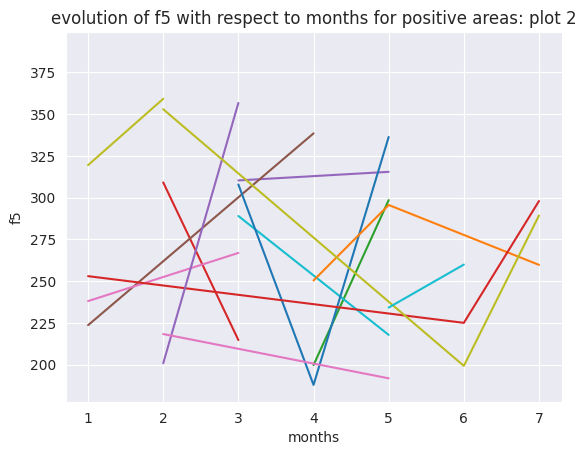

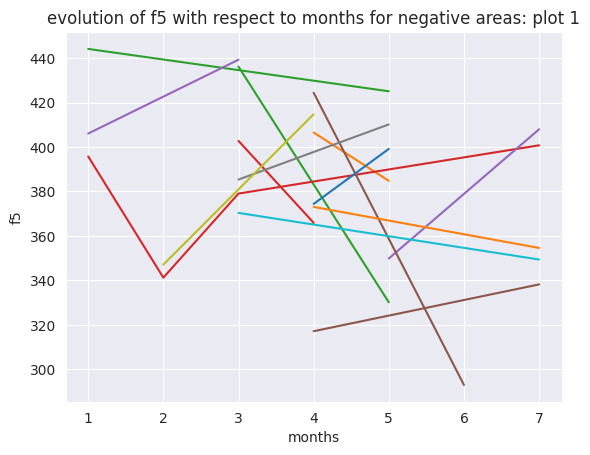

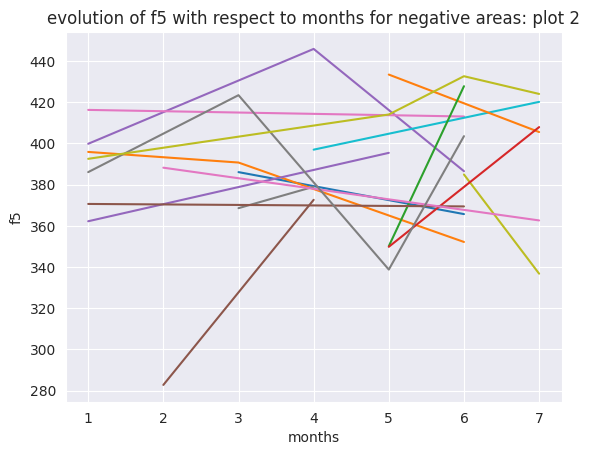

In [23]:
cols = ['f1', 'f2', 'f5']
for c in cols:
    feat_month_country(c)

The visualizations display chaotric interaction between the different features grouped by the country ('f3') column and the date column ('f7'). 
Thus, we can safely assume the month + country combination has little to no correlation with the numerical features. 

In [24]:
# print(pd.pivot_table(df, index='f3', columns=month, values='f6', aggfunc=['count']))
# print(pd.pivot_table(df, index='f3', columns=month, values='f6', aggfunc=['mean']))
print(pd.pivot_table(df, index=month, values='f6', aggfunc=['count', 'mean'])) # the month does not correlate with f6.

      count      mean
         f6        f6
month                
1       136  0.536765
2       141  0.553191
3       142  0.436620
4       141  0.531915
5       138  0.536232
6       131  0.511450
7        96  0.562500


In [25]:
# let's consider the evolution of different values with respect to the months regardless of the country column
# we can acheive that using box plots
def feat_month(feat, aggs=None):
    if aggs is None:
        aggs = [np.mean]
    f_month = pd.pivot_table(df, index=month, values=feat, aggfunc=aggs)
    for stat in aggs:
        fig = sns.relplot(kind="line", ci=None, data=f_month, x='month', y=f_month[(stat, feat)])
        fig.fig.suptitle(f"{stat}'s variation of {feat} with respect to the month")
    plt.show()

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: 

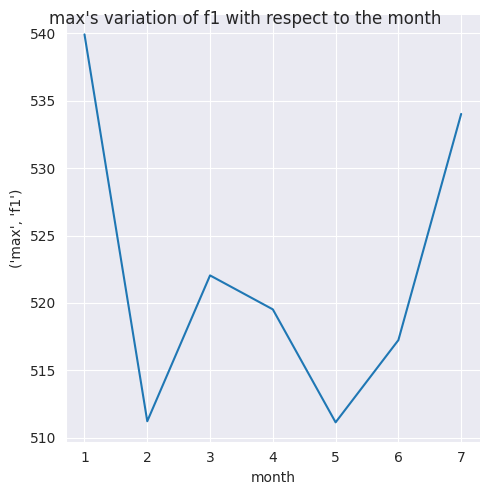

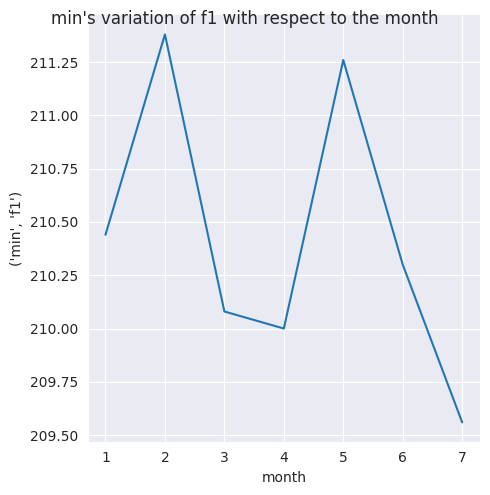

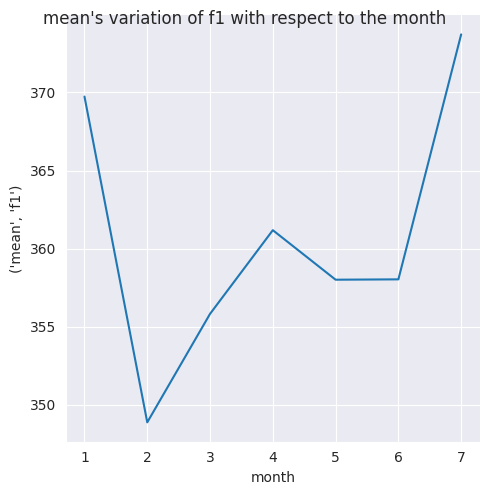

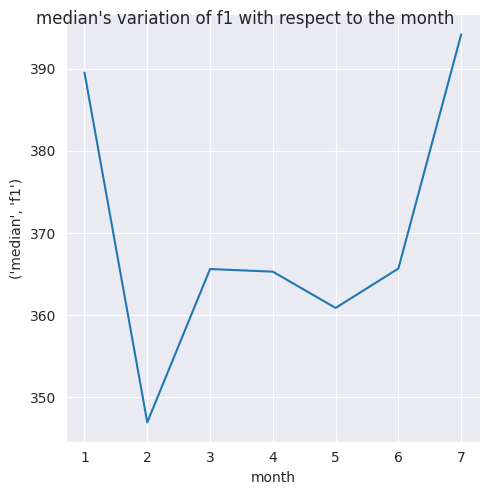

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: 

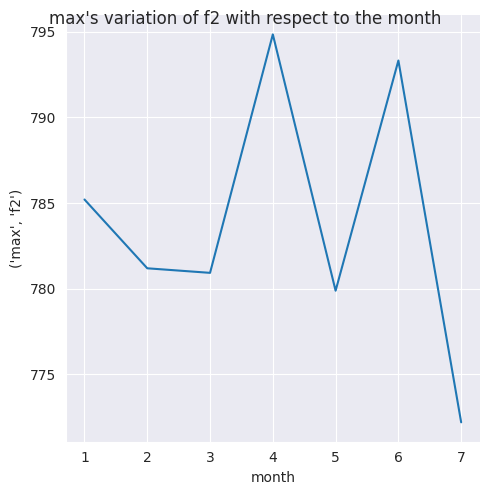

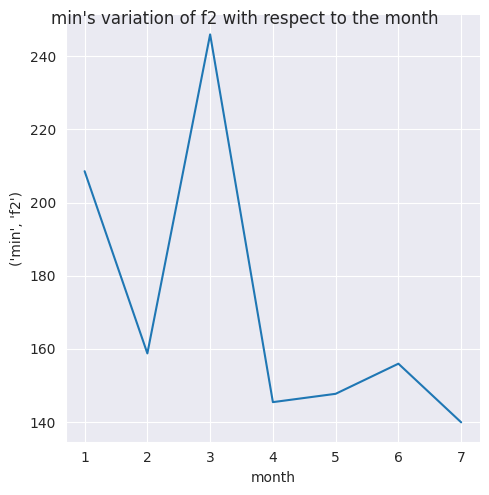

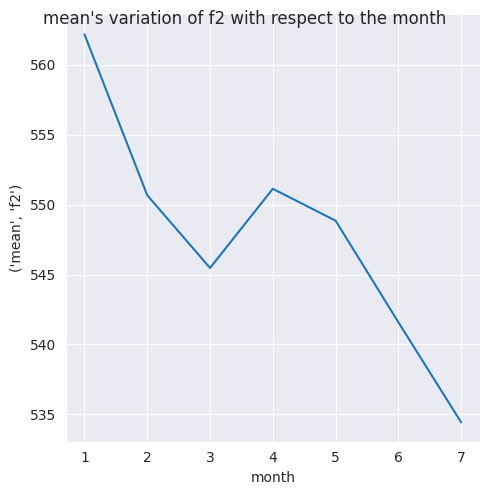

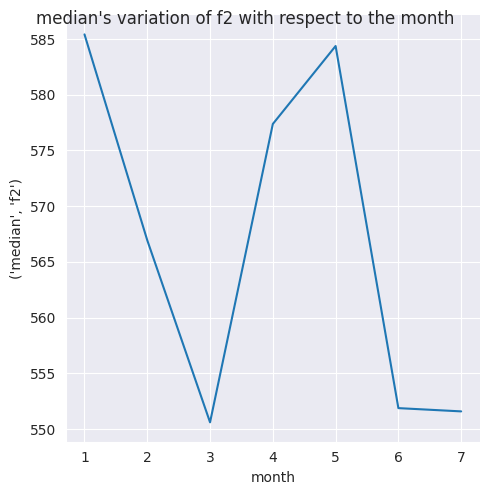

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: 

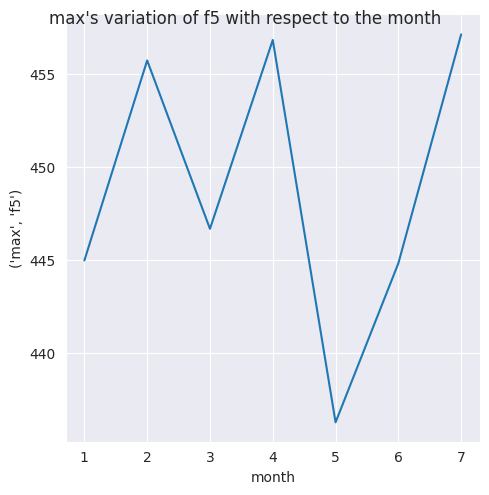

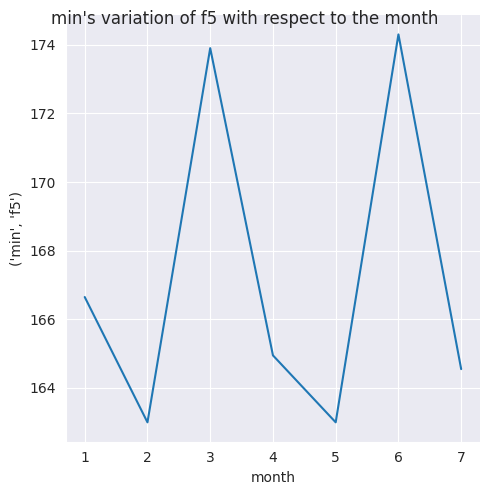

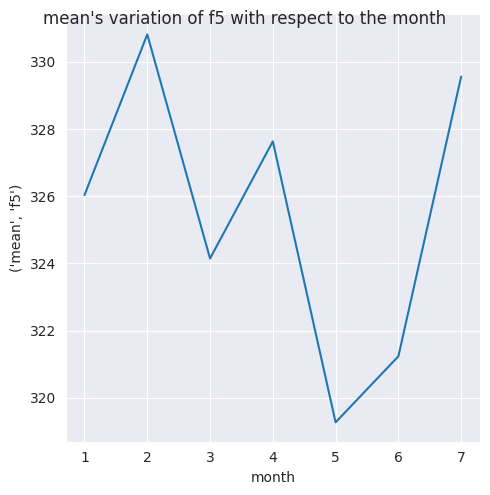

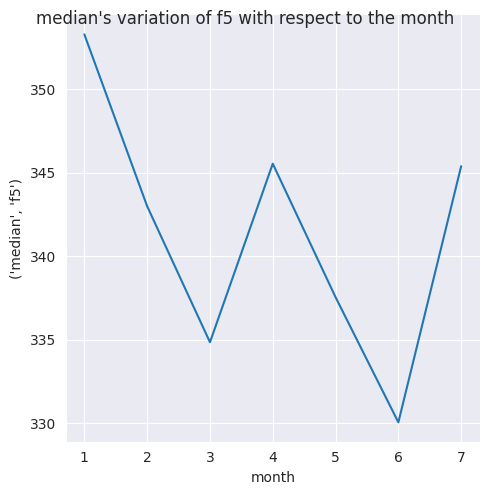

In [26]:
for f in ['f1', 'f2', 'f5']:
    feat_month(f, ['max', 'min', 'mean', 'median'])

#### Conclusion
As we can see from the last two subsections, the date reduced to the month value (as the year is the same across the dataset) does not correlate by any mean with neither the country, target or even the (non-missing) numerical features.  
The only possible use of the 'f7' column is impute the 'f4' missing values (if possible)

#### 'f6' column
It is time to consider the interaction between the categorical feature 'f6' and the target variable

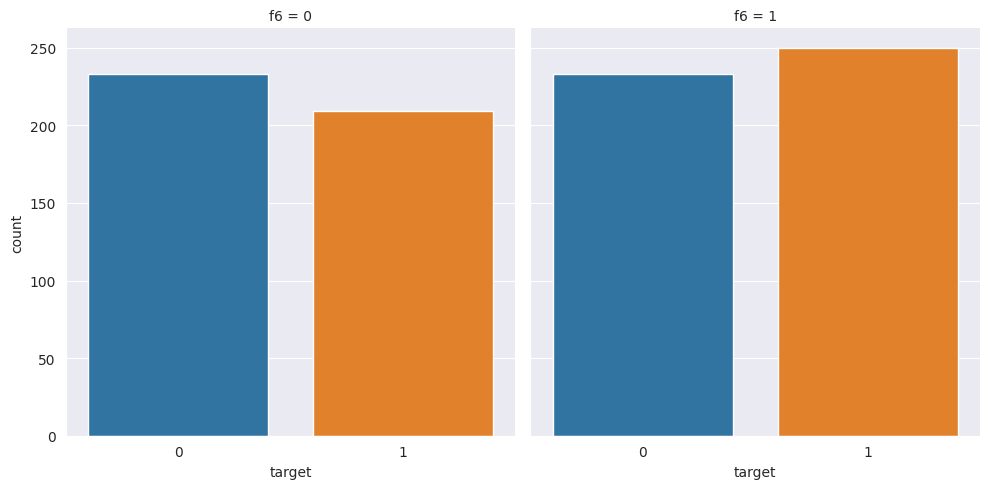

In [27]:
g = sns.catplot(kind='count', ci=None, data=df, x='y', col='f6', col_order=[0, 1])
g.set(xlabel='target')
plt.show()


In [28]:
# the plot above reveals the value of 'f6' has little to no effect the final classification
# let's calcuate the corretation between these two values to solidify this observation
print(df.loc[:, ['f6', 'y']].corr())

          f6         y
f6  1.000000  0.044705
y   0.044705  1.000000


## Imputing the f4 column
As the 'f4' column misses 600 values, it is of absolute necessity to fill these missing values. In our case, the imputing method would be building a regression model predicting the missing values. 

In [29]:
# df.drop('y', axis=1, inplace=True)
df_4 = df[~df['f4'].isna()]
print(df_4.shape)
print(df.columns)

(325, 8)
Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'month', 'y'], dtype='object')


### Exploring the data in relation to f4
In this subsection, we are tackling a sub problem. However, it is a still a different problem (a regression to say the least), so it should approached accordingly.


/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='f4', ylabel='Density'>

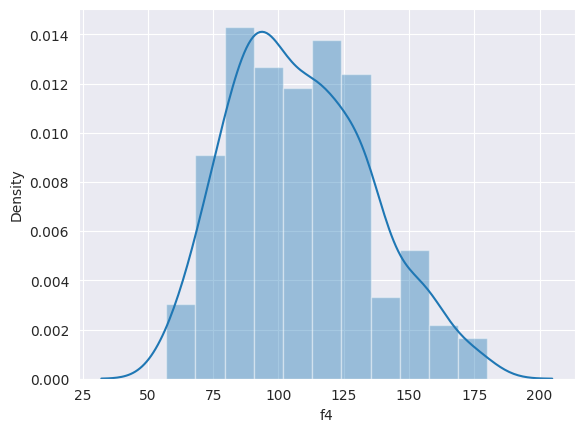

In [30]:
sns.distplot(df_4['f4'])
# we can see that the distribution of 'f4' is not too far from normal distribution.

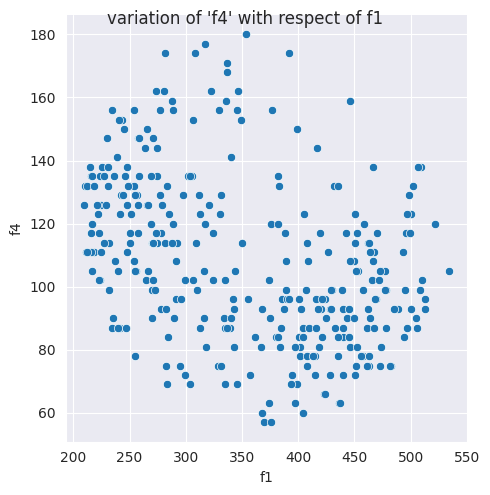

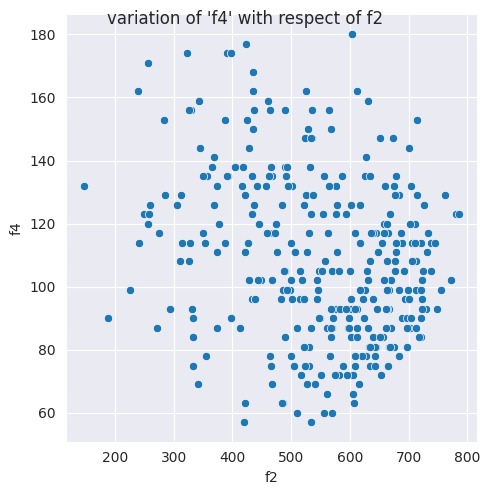

In [31]:
# let's visualize the relation of 'f4' with the rest of the columns
for col in num_cols[:-2]:
    g = sns.relplot(kind='scatter', data=df_4, x=col, y='f4')
    g.fig.suptitle(f"variation of 'f4' with respect of {col}")
    g.set(xlabel=col, ylabel='f4')
    plt.show()

The visualizations demonstrate that the relations between f4 and the other numerical (continous) features are definitely non-linear. Thus further experiementing is needed to reveal the hidden interactions.

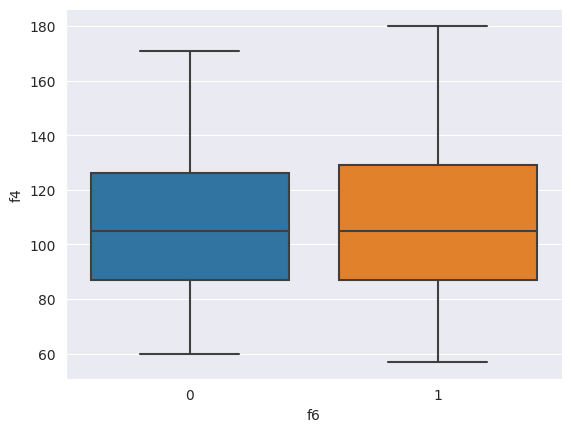

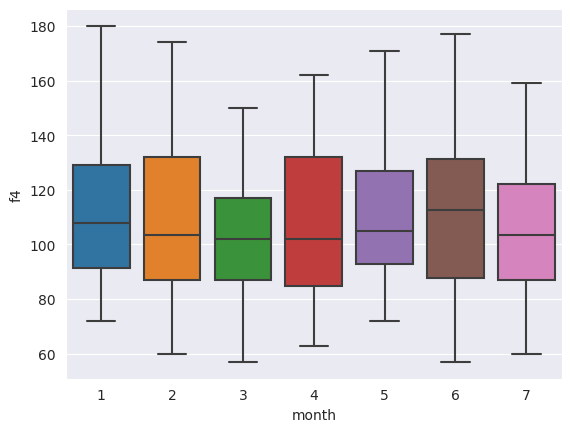

In [32]:
# let's investigate the effect of categorical features 
sns.boxplot(data=df_4, y='f4', x='f6')
plt.show()
sns.boxplot(data=df_4, y='f4', x=month)
plt.show()

Further, the first plot demonstrates that f6 provides almost no information about f4 as the variation of f4 for both categories is roughly the same.

In [33]:
f4_by_area = pd.pivot_table(df_4, index='f3', values='f4', aggfunc=['count', 'max', 'min', 'mean','median'])
# f3 is the most informative predictor so far. 
f4_by_month = pd.pivot_table(df_4, index=month, values='f4', aggfunc=['count', 'median'])
def encode_area(row):
    area = row['f3']
    # encode the area as the mean of f4 for that area
    if area in f4_by_area.index.values:
        row['f3'] = f4_by_area[('mean', 'f4')][area]
    # if the area if seen for the first time: encode it as the median of f4 by corresponding month
    else:
        mo = row[month]
        row['f3'] = f4_by_month[('median', 'f4')][mo]
    return row
print(f4_by_area)
print(f4_by_month)

                  count    max    min    mean median
                     f4     f4     f4      f4     f4
f3                                                  
afghanistan           2  177.0  120.0  148.50  148.5
albania               1  102.0  102.0  102.00  102.0
algeria               4  108.0   72.0   92.25   94.5
american samoa        1   87.0   87.0   87.00   87.0
andorra               2  102.0   78.0   90.00   90.0
...                 ...    ...    ...     ...    ...
vietnam               2  114.0   99.0  106.50  106.5
wallis and futuna     2  111.0  105.0  108.00  108.0
western sahara        3  123.0  111.0  117.00  117.0
yemen                 1  102.0  102.0  102.00  102.0
zambia                2  102.0   96.0   99.00   99.0

[180 rows x 5 columns]
      count median
         f4     f4
month             
1        47  108.0
2        44  103.5
3        56  102.0
4        42  102.0
5        48  105.0
6        50  112.5
7        38  103.5


In [34]:
df_imp = df[df['f4'].isna()]
print(df_imp.shape)

(600, 8)


In [35]:
df_4 = df_4.apply(encode_area, axis=1) # encode the f3 column for the complete data
df_imp = df_imp.apply(encode_area, axis=1) # encode the f3 column for the missing data

### Imputing the missing values: different models

In [36]:
# let's divide the training data into training and test data: to evaluate the performance
from sklearn.model_selection import train_test_split
yf4 = df_4['f4']
df_4.drop('f4', axis=1, inplace=True)

df_4, df_test, yf4, y_test = train_test_split(df_4, yf4, test_size=0.2, random_state=11)

In [37]:
# copy the dataframe in question for experimenting
from sklearn.preprocessing import StandardScaler # used to scale the data
scaler = StandardScaler()

df_tmp = df_4.iloc[:, :4]
Xs = scaler.fit_transform(df_tmp)
df_t = pd.DataFrame(Xs, columns=df_tmp.columns)
df_t['f6'] = df_4['f6'].values
df_t[month] = df_4[month].values
df_t.head()

,f1,f2,f3,f5,f6,month
0,0.753519,1.374171,0.184098,0.660472,1,3
1,1.676366,0.393168,-0.956793,0.039218,1,4
2,0.268483,0.126927,2.465880,-1.635881,0,5
3,-0.759845,-0.464336,-0.386347,-1.236957,0,1
4,-0.138214,0.013624,-0.956793,1.471024,0,2


In [38]:
# standarize the test dataset as well
df_tmp = df_test.iloc[:, :4]
Xs = scaler.transform(df_tmp)
df_t = pd.DataFrame(Xs, columns=df_tmp.columns)
df_t['f6'] = df_test['f6'].values
df_t[month] = df_test[month].values
df_t.head()

,f1,f2,f3,f5,f6,month
0,-1.409501,0.237778,0.547109,-0.502632,0,3
1,-0.245460,1.831339,0.443392,0.159912,1,3
2,-1.346610,0.221180,0.443392,-0.727503,0,2
3,1.225976,-0.319488,0.443392,1.495163,0,3
4,-1.416784,0.427676,-0.386347,-0.110696,0,7


#### Polynomial Regression
The previous analysis conducted above displays the non-linear interaction between f4 and the rest of the feature. Thus a simple Linear Regression will clear underfits.

In [39]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=3, shuffle=True, random_state=11)

In [40]:
sk.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [41]:
from sklearn.preprocessing import PolynomialFeatures

# I will try polynomial features with degrees 2, 3, 4, 5
# the choice will be determined using cross validation
X_4_train = df_4.values
y_4_train = yf4.values

polys = [PolynomialFeatures(degree=i) for i in range(2, 6)]
X_trains = [p.fit_transform(X_4_train) for p in polys]    
# intiate a Linear Regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

best_score = 10 ** 9
best_deg = 0
scoring = "neg_mean_squared_error"
for i in range(len(X_trains)): 
    score = -np.mean(cross_val_score(lr, X_trains[i], y_4_train, cv=cv, scoring=scoring))
    
    print(f"degree: {str(i + 2)}" )
    print(f"score: {str(np.mean(score))}")
    if best_score > score:
        best_score = score
        best_deg = i + 2
   
print(best_deg)
print(best_score)

degree: 2
score: 285.2632574297236
degree: 3
score: 1816.207204488174
degree: 4
score: 84535.65305916079
degree: 5
score: 62933.22335462606
2
285.2632574297236


In [42]:
# as the size of the dataset is relatively small, our model is likely to overfit: Lasso and Ridge are more likely to be better options
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
lasso = Lasso()
parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

lasso_search = GridSearchCV(lasso, parameters, cv=cv, scoring=scoring, n_jobs=-1)

lasso_search.fit(X_trains[best_deg - 2], y_4_train)

lasso_est = lasso_search.best_estimator_

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+04, tolerance: 1.213e+01
  model = cd_fast.enet_coordinate_descent(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+04, tolerance: 1.147e+01
  model = cd_fast.enet_coordinate_descent(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converg

In [43]:
from sklearn.metrics import mean_squared_error

X_test = polys[best_deg - 2].transform(df_test.values)

f4_pred = lasso_est.predict(X_test)
print(mean_squared_error(y_test, f4_pred))

233.76527366865287


In [44]:
error_dicts = dict(zip(y_test.tolist(), f4_pred.tolist()))
print(error_dicts)

{111.0: 104.22198019491, 123.0: 112.07636136896252, 132.0: 119.38943885260659, 126.0: 115.57866655580972, 93.0: 103.01204487338303, 87.0: 121.28402146817494, 114.0: 99.084407089803, 81.0: 89.61700823567573, 102.0: 102.9767611753316, 72.0: 79.03980375408247, 171.0: 194.39604345618034, 105.0: 90.1376044708768, 99.0: 95.65917067273995, 84.0: 86.74060083678788, 60.0: 58.964110419712185, 63.0: 67.98641587584703, 75.0: 79.69824189071919, 135.0: 119.31442358347178, 117.0: 123.16528899567118, 90.0: 101.87371901821547, 138.0: 116.96633691260848, 150.0: 150.10744209089796, 120.0: 120.6055948128533, 129.0: 101.49884783808115, 108.0: 119.71605969666953, 159.0: 111.63964654873283, 144.0: 118.94427097629412, 147.0: 154.0755876763264, 141.0: 131.40941993881918}


In [45]:
ridge = Ridge()
parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

ridge_search = GridSearchCV(ridge, parameters, cv=cv, scoring=scoring, n_jobs=-1)

ridge_search.fit(X_trains[best_deg - 2], y_4_train)

ridge_est = ridge_search.best_estimator_ 

ridge_f4_pred = ridge_est.predict(X_test)
print(mean_squared_error(y_test, ridge_f4_pred))

214.68436585124542


In [46]:
error_dicts = dict(zip(y_test.tolist(), ridge_f4_pred.tolist()))
print(error_dicts)

{111.0: 99.76009375284548, 123.0: 111.37585559662745, 132.0: 117.80884461779931, 126.0: 117.97825312663286, 93.0: 96.46010712521769, 87.0: 118.34430100172983, 114.0: 102.23573917031541, 81.0: 90.03832274019726, 102.0: 102.42203670632045, 72.0: 78.4673202226337, 171.0: 197.56083587041957, 105.0: 93.00308405450659, 99.0: 96.89135666019217, 84.0: 87.1210343382844, 60.0: 61.92224997334006, 63.0: 70.79190469726541, 75.0: 82.2233850653314, 135.0: 117.22844484490156, 117.0: 122.72563542731075, 90.0: 96.61227726204004, 138.0: 117.43198230263044, 150.0: 151.53686066128762, 120.0: 122.26405894436823, 129.0: 105.5788448427594, 108.0: 118.60122754536542, 159.0: 116.73217608319294, 144.0: 121.12302076937362, 147.0: 152.5278056921714, 141.0: 129.18885646992788}


In [47]:
lasso_linear = Lasso()
parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

lasso_lin_search =  GridSearchCV(lasso_linear, parameters, cv=cv, scoring=scoring, n_jobs=-1)
lasso_lin_search.fit(X_4_train, y_4_train)

lasso_lin_est = lasso_lin_search.best_estimator_
print(lasso_lin_est.coef_)

lasso_lin_pred = lasso_lin_est.predict(df_test.values)

print(mean_squared_error(y_test, lasso_lin_pred))

[ 3.36663468e-02 -4.06884124e-03  9.01891595e-01  3.93239861e-02
 -4.49997720e+00 -3.63241092e-01  2.27033379e+01]
247.90776513014242


In [ ]:
## ONE HOT ENCODING
## as I did with Target Encoding, I will replace the f3 column with an old version
df_OHE = df_bef_train.copy()
ohe = OneHotEncoder(sparse=False)

X = ohe.fit_transform(df_OHE[['f3']])
df_OHE = pd.concat([df_OHE.drop('f3', axis=1), pd.DataFrame(X, columns=ohe.get_feature_names_out())], axis=1)

In [ ]:
# make sure to use the exact split used for the previous training-part
df_ohe_train = df_OHE.loc[df_train.index.values, :]
df_ohe_test = df_OHE.loc[df_test.index.values, :]

for f in functions:
    f(df_ohe_train, df_ohe_test, y_train, y_test)

best_red_dim(df_ohe_train, df_ohe_test, y_train, y_test)